In [102]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib
import cv2
import os
import imghdr
import pandas as pd
from tensorflow.keras import layers
import tensorflow_io as tfio

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Sequential, load_model
from PIL import Image

from os import listdir
from os.path import join
from numpy import expand_dims

print(f"TensorFlow Version:{tf.__version__}")
print(f'Keras Version:{keras.__version__}')
print(f"Numpy Version:{np.__version__}")
print(f'PIL Image Version:{Image.__version__}')
print(f'Matplotlib Version:{matplotlib.__version__}')


TensorFlow Version:2.9.2
Keras Version:2.9.0
Numpy Version:1.23.4
PIL Image Version:9.3.0
Matplotlib Version:3.6.0


In [2]:
data_dir = "D:\\DogsAndCats\\example\\"


In [3]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']


In [4]:
img = cv2.imread(join(data_dir, 'cat', 'cat.0.jpg'))
img.shape


(374, 500, 3)

In [105]:
image = tf.image.decode_jpeg(tf.io.read_file('cat-test.jpg'))
grayscale = tfio.experimental.color.rgb_to_grayscale(image)

TensorShape([340, 557, 1])

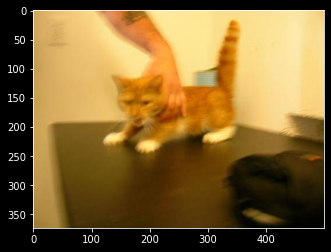

In [5]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [6]:
for image_class in listdir(data_dir):
    for image in listdir(join(data_dir, image_class)):
        image_path = join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except:
            print("Issue with image {}".format(image_path))


In [7]:
tf.data.Dataset??


Init signature: tf.data.Dataset(variant_tensor)
Source:        
class DatasetV2(collections_abc.Iterable, tracking_base.Trackable,
                composite_tensor.CompositeTensor):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Tensor(3, shape=(), dtype=int32)

  To process lines from files, use 

In [8]:
tf.keras.utils.image_dataset_from_directory??


Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export('keras.utils.image_dataset_from_directory',
              'keras.preprocessing.image_dataset_from_directory',
              v1=[])
def image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=32,
                                 image_size=(256, 256),
                                 shuffle=True,
                                 seed=None,
               

In [142]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(28,28))


Found 57 files belonging to 2 classes.


In [143]:
data = data.map(lambda x, y: (tfio.experimental.color.rgb_to_grayscale(x), y))

In [144]:
data_iterator = data.as_numpy_iterator()


In [145]:
batch = data_iterator.next()


In [146]:
batch[0].shape


(32, 28, 28, 1)

In [147]:
# class 1 = DOG
# class 0 = CAT
batch[1]


array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

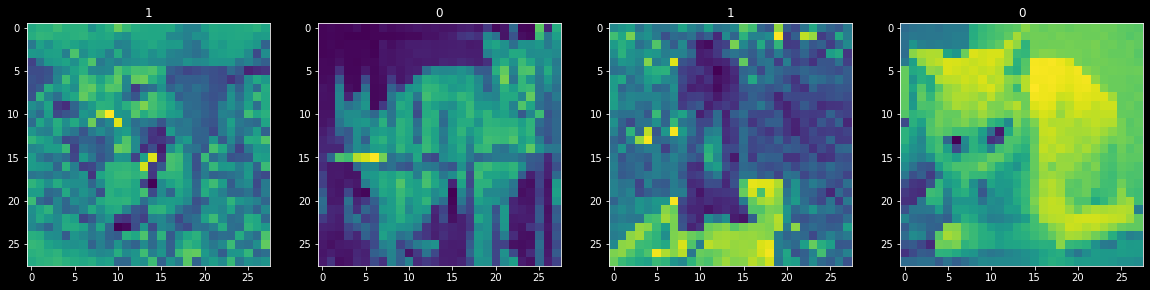

In [161]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img, in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


In [162]:
batch[0].min()


0.0

In [163]:
batch[0].max()


255.0

In [164]:
scaled = batch[0] / 255


In [165]:
scaled.max()


1.0

In [166]:
data = data.map(lambda x, y: (x/255, y))


In [167]:
scaled_iterator = data.as_numpy_iterator()


In [168]:
batch = scaled_iterator.next()


In [169]:
batch[0].max()


0.003921569

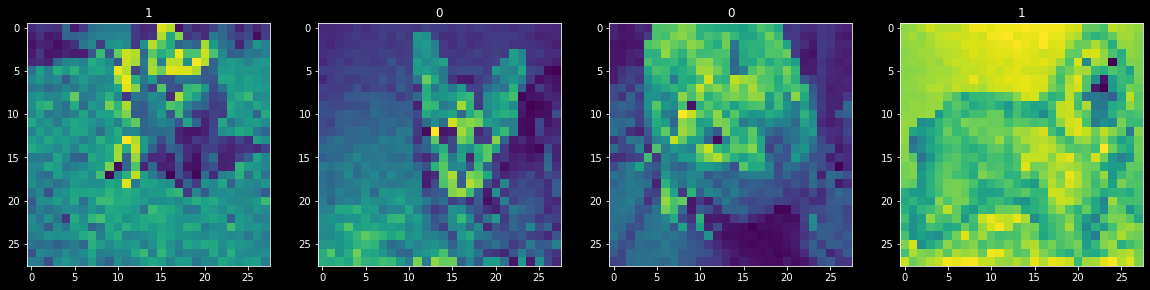

In [170]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img, in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


In [171]:
len(data)


2

In [172]:
train_size = int(len(data) * .5)
val_size = int(len(data) * .2) + 1
test_size = int(len(data) * .1) + 1


In [173]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).take(test_size)


In [174]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [175]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2,
                  padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 14, 14, 32)   320         ['input_11[0][0]']               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_13[0][0]']              
                                                                                                  
 flatten_6 (Flatten)            (None, 3136)         0           ['conv2d_14[0][0]']              
                                                                                            

In [176]:
latent_inputs = keras.Input(shape=(latent_dim))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu",
                           strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu",
                           strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(
    1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_13 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 28, 28, 1)        289 

In [177]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var -
                              tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [183]:
# mnist_digits = np.concatenate([train,test], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

for i, image in enumerate(train.as_numpy_iterator()):
    vae.fit(image[i], epochs=30, batch_size=128)


Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 19.3145 - reconstruction_loss: 19.0678 - kl_loss: 0.2467
Epoch 2/30
1/1 [==============================] - 0s 82ms/step - loss: 19.1204 - reconstruction_loss: 18.8006 - kl_loss: 0.3197
Epoch 3/30
1/1 [==============================] - 0s 88ms/step - loss: 17.3977 - reconstruction_loss: 17.0465 - kl_loss: 0.3512
Epoch 4/30
1/1 [==============================] - 0s 52ms/step - loss: 16.9344 - reconstruction_loss: 16.5890 - kl_loss: 0.3454
Epoch 5/30
1/1 [==============================] - 0s 49ms/step - loss: 16.6159 - reconstruction_loss: 16.3056 - kl_loss: 0.3102
Epoch 6/30
1/1 [==============================] - 0s 53ms/step - loss: 16.4736 - reconstruction_loss: 16.2081 - kl_loss: 0.2655
Epoch 7/30
1/1 [==============================] - 0s 54ms/step - loss: 15.7020 - reconstruction_loss: 15.4826 - kl_loss: 0.2194
Epoch 8/30
1/1 [==============================] - 0s 58ms/step - loss: 14.9552 - reconstruction_loss: 14.7

1/1 [==============================] - 0s 46ms/step


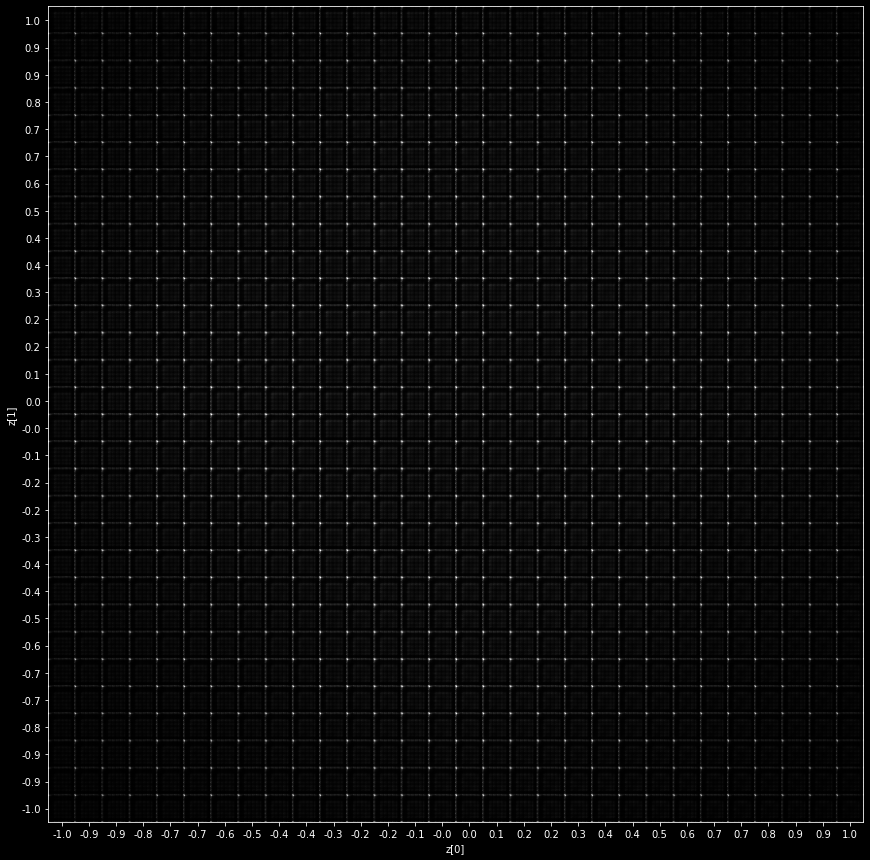

In [184]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

In [27]:
model = Sequential()


In [59]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


TypeError: __init__() got multiple values for argument 'strides'

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [30]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [31]:
logs_dir = 'logs'


In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logs_dir)


In [33]:
hist = model.fit(train, epochs=20, validation_data=val,
                 callbacks=[tensorboard_callback])


Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 0.6826 - accuracy: 0.5312 - val_loss: 1.4648 - val_accuracy: 0.5200
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 1.6955 - accuracy: 0.4375 - val_loss: 1.1043 - val_accuracy: 0.6400
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 1.1128 - accuracy: 0.5938 - val_loss: 0.9365 - val_accuracy: 0.5200
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 1.0581 - accuracy: 0.5000 - val_loss: 0.7212 - val_accuracy: 0.5200
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.6919 - accuracy: 0.5625 - val_loss: 0.6930 - val_accuracy: 0.4400
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.6861 - accuracy: 0.4688 - val_loss: 0.6896 - val_accuracy: 0.5200
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.6710 - accuracy: 0.5312 - val_loss: 0.6702 - val_accuracy: 0.5200
Epoch 8/20
1/1 [=========================

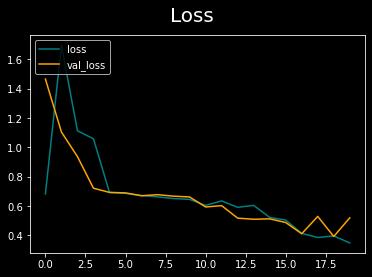

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()


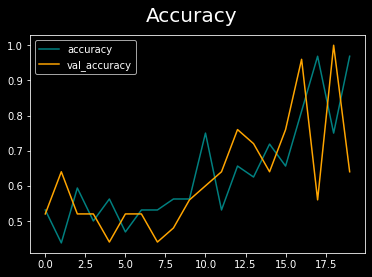

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [37]:
len(test)


1

In [38]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 [==============================] - 0s 429ms/step


In [39]:
print(
    f'Precission:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


Precission:0.5454545617103577, Recall:1.0, Accuracy:0.6000000238418579


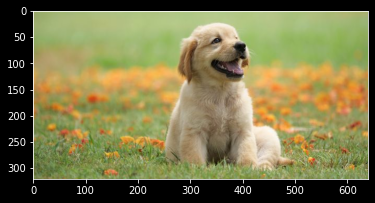

In [40]:
img = cv2.imread('dog-test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


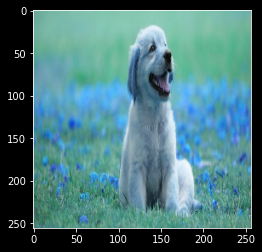

In [41]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [42]:
resize.shape


TensorShape([256, 256, 3])

In [43]:
expand_dims(resize, 0).shape


(1, 256, 256, 3)

In [44]:
predict = model.predict(expand_dims(resize/255, 0))
print(predict[0][0])
val_predict = float(np.format_float_positional(predict[0][0], precision=3))
val_predict


1/1 [==============================] - 0s 48ms/step
0.9201678


0.92

In [45]:
if val_predict <= 0.43:
    print("is a cat class")
else:
    print("is a dog class")


is a dog class


In [46]:
df = pd.DataFrame()
list_cats = []
list_dogs = []
list_animals = []

for file in listdir(join('D:\\DogsAndCats', 'test')):
    path = join('D:\\DogsAndCats', 'test', file)
    img = cv2.imread(path)
    resize = tf.image.resize(img, (256, 256))
    dim = expand_dims(resize/255, 0)
    predict = model.predict(dim)
    list_animals.append(predict[0][0])

print(f'Total carregados {len(list_animals)}')

1/1 [==============================] - 0s 34ms/step
Total carregados 10


In [47]:
df['animals'] = list_animals

df['cat'] = df['animals'] <= 0.45
df['dog'] = df['animals'] >= 0.45
df = df.astype({'cat': int, 'dog': int})

print('total cats {}'.format(df['cat'].sum()))
print('total dog {}'.format(df['dog'].sum()))

total cats 0
total dog 10


In [48]:
fig = px.scatter(df, x="animals", y="cat", color="animals",
                 hover_data=['dog', 'cat', 'animals'])
fig.show()


# Save Model

In [49]:
model.save(join('D:\\DogsAndCats\\', 'models', 'image_classifier.h5'))
new_model = load_model(join('D:\\DogsAndCats', 'models', 'image_classifier.h5'))


In [50]:
new_predict = new_model.predict(expand_dims(resize/255, 0))
new_predict = float(np.format_float_positional(new_predict[0][0], precision=3))
new_predict

if new_predict <= 0.51:
    print("is a cat class")
else:
    print("is a dog class")


1/1 [==============================] - 0s 161ms/step
is a dog class
